In [ ]:
K Poojitha Reddy
RA2011026020092

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [2]:
# a) Exploratory Data Analysis & Data pre-processing
data = pd.read_excel("data.xlsx", sheet_name="Data")
X = data.drop("MEMBERSHIP_STATUS", axis=1)
y = data["MEMBERSHIP_STATUS"]
label_encoder = LabelEncoder()
y_binary = label_encoder.fit_transform(y)

In [3]:
# b) Split the data into training and test. Fit a model and score it with the test data
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)
numerical_columns = ['MEMBERSHIP_TERM_YEARS', 'ANNUAL_FEES', 'MEMBER_ANNUAL_INCOME', 'MEMBER_AGE_AT_ISSUE', 'ADDITIONAL_MEMBERS']
categorical_columns = ['MEMBER_MARITAL_STATUS', 'MEMBER_GENDER', 'MEMBER_OCCUPATION_CD', 'MEMBERSHIP_PACKAGE', 'PAYMENT_MODE']
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
param_dist = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

best_params_random = random_search.best_params_

best_model_random = random_search.best_estimator_
y_pred_best_random = best_model_random.predict(X_test)
print("Accuracy :", accuracy_score(y_test, y_pred_best_random))
print("Classification Report", classification_report(y_test, y_pred_best_random))




Accuracy : 0.7134587554269175
Classification Report               precision    recall  f1-score   support

           0       0.60      0.13      0.21       620
           1       0.72      0.96      0.82      1453

    accuracy                           0.71      2073
   macro avg       0.66      0.55      0.52      2073
weighted avg       0.68      0.71      0.64      2073



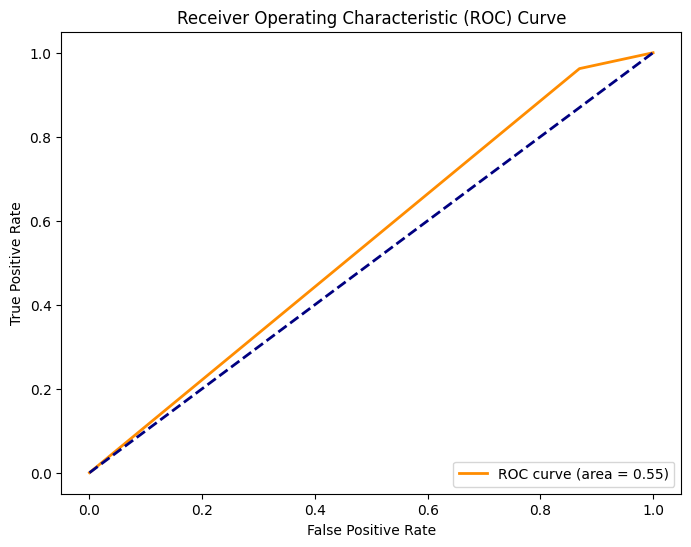

ROC AUC for class CANCELLED: 0.546396221388451
ROC AUC for class INFORCE: 0.546396221388451


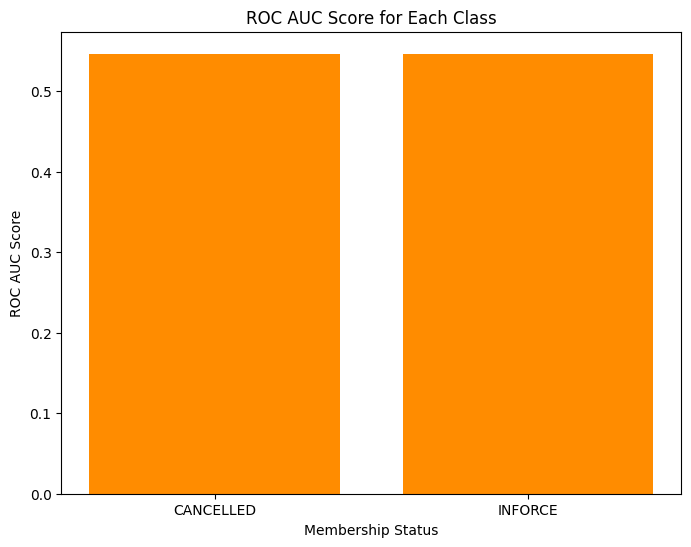

In [4]:
# c) Confusion Matrix Table (or) AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_best_random)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate ROC AUC for each class
roc_auc_scores = []
for i in range(len(label_encoder.classes_)):
    y_true_class = (y_test == i).astype(int)
    y_pred_class = (y_pred_best_random == i).astype(int)
    
    roc_auc = roc_auc_score(y_true_class, y_pred_class)
    roc_auc_scores.append(roc_auc)
    print(f'ROC AUC for class {label_encoder.classes_[i]}: {roc_auc}')

# Plot ROC AUC for each class
plt.figure(figsize=(8, 6))
plt.bar(label_encoder.classes_, roc_auc_scores, color='darkorange')
plt.xlabel('Membership Status')
plt.ylabel('ROC AUC Score')
plt.title('ROC AUC Score for Each Class')
plt.show()